# Q1

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
mdLog = pd.read_csv('mdlog.csv',index_col = 0)
mdLog

In [46]:
mdLog['spread'] = mdLog['ask'] - mdLog['bid']
mdLog['spread_d'] = mdLog['spread'].diff().apply(lambda x: round(x, 2))
mdLog['bid_d'] = mdLog['bid'].diff().apply(lambda x: round(x, 2))
mdLog['ask_d'] = mdLog['ask'].diff().apply(lambda x: round(x, 2))

print((mdLog['spread_d'] > 0).sum())
print(((mdLog['spread_d'] > 0) & (mdLog['bid_d'] <0) & (mdLog['ask_d'] > 0)).sum())
print(((mdLog['spread_d'] > 0) & ((mdLog['bid_d'] <0) ^ (mdLog['ask_d'] > 0))).sum())

233
1
232


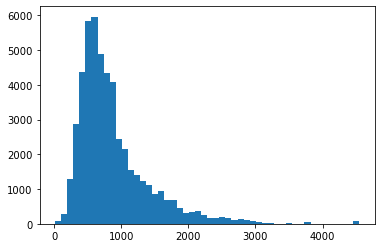

In [54]:
mdLog['market_size'] = (mdLog['bidsize'] + mdLog['asksize'])/2
plt.hist(mdLog['market_size'], bins = 50)
plt.show()

In [60]:
mdLog['mid_price'] = (mdLog['ask'] + mdLog['bid'])/2
mdLog['mid_price_d'] = mdLog['mid_price'].diff()

mask = (mdLog['mid_price_d'] != 0) & (mdLog['spread_d'] == 0)
mdLog_mid_change = mdLog[mask]

In [65]:
mdLog_mid_change.loc[:,'aggresive_size'] = mdLog_mid_change.apply(lambda row: row['bidsize'] if row['mid_price_d'] > 0 else row['asksize'], axis = 1)
mdLog_mid_change.loc[:,'defensive_size'] = mdLog_mid_change.apply(lambda row: row['asksize'] if row['mid_price_d'] > 0 else row['bidsize'], axis = 1)

C:\Users\a\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


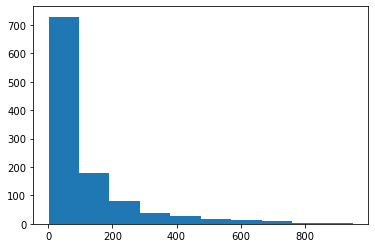

In [67]:
plt.hist(mdLog_mid_change['aggresive_size'])
plt.show()

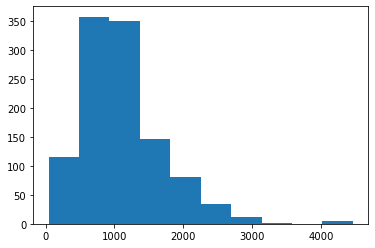

In [68]:
plt.hist(mdLog_mid_change['defensive_size'])
plt.show()

# Q3

In [108]:
# mdLog['lastprice'].value_counts().index.tolist()
mdLog['trades'] = mdLog['volume'].diff()
volume_count = {}
for idx in range(2,len(mdLog)):
    cur_price = round(mdLog.loc[idx,'lastprice'],2)
    last_price = round(mdLog.loc[idx,'lastprice'],2)
    trades = mdLog.loc[idx,'trades']
    lo = min(cur_price,last_price)
    hi = max(cur_price,last_price)
    num_levels = (hi-lo+0.01)/0.01
    for price in np.arange(lo,hi+0.01,0.01):
        price = round(price,2)
        volume_count[price] = volume_count.get(price,0) + trades / num_levels



In [110]:
mdLog['lastprice_d'] = mdLog['lastprice'].diff() 
mdLog['trade_at_last_price'] = mdLog['trades'] / (abs(mdLog['lastprice'].diff()/0.01) + 1) 

# Q4

In [133]:
mdLog['sizeDeltaAtBid'] = mdLog['bidsize'].diff() +  mdLog['trade_at_last_price']
mdLog.loc[mdLog['bid_d'] != 0,'sizeDeltaAtBid'] = 0

mdLog['sizeDeltaAtAsk'] = mdLog['asksize'].diff() +  mdLog['trade_at_last_price']
mdLog.loc[mdLog['ask_d'] != 0,'sizeDeltaAtAsk'] = 0

In [166]:
((mdLog['sizeDeltaAtBid'] > 0) & (mdLog['mid_price_d'] > 0)).sum()

102

In [172]:
num_top_order = 0
num_entire_BBO = 0
num_filled_original = 0

for idx in mdLog.index:
    if mdLog.loc[idx,'mid_price_d'] > 0 and mdLog.loc[idx,'sizeDeltaAtBid'] > 0:
        num_top_order += 1
        #aggresive_side = 'bid' 
        order_size = mdLog.loc[idx,'sizeDeltaAtBid']
        bid_price = mdLog.loc[idx,'bid']
        original_size = True
        idx += 1
        while(mdLog.loc[idx,'bid'] == bid_price and order_size > 0):
            trades = mdLog.loc[idx,'trade_at_last_price']
            bid_size = mdLog.loc[idx,'bidsize']
            if trades < order_size:
                order_size -= trades
            else:
                order_size =0
                break
            if bid_size < order_size:
                order_size = bid_size
                original_size = False
            idx+=1
        if order_size == 0:
            num_entire_BBO += 1
        if original_size:
            num_filled_original +=1
        

    if mdLog.loc[idx,'mid_price_d'] < 0 and mdLog.loc[idx,'sizeDeltaAtAsk'] > 0:
        num_top_order += 1
        order_size = mdLog.loc[idx,'sizeDeltaAtAsk']
        bid_price = mdLog.loc[idx,'ask']
        original_size = True
        idx += 1
        while(mdLog.loc[idx,'bid'] == bid_price and order_size > 0):
            trades = mdLog.loc[idx,'trade_at_last_price']
            ask_size = mdLog.loc[idx,'ask']
            if trades < order_size:
                order_size -= trades
            else:
                order_size =0
                break
            if ask_size < order_size:
                order_size = ask_size
                original_size = False
            idx+=1
        if order_size == 0:
            num_entire_BBO += 1
        if original_size:
            num_filled_original +=1
        
    

In [175]:
print(num_top_order)
print(num_entire_BBO)
print(num_filled_original)

196
30
194
